In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import gc
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import plot_importance
# Assuming the training_preprocess.py file is in the same directory
from training_preprocess import dataset

In [2]:
# Display the first few rows of the dataset to verify the preprocessing
dataset.head()

,ip,app,device,os,channel,is_attributed,day,hour,minute,second
0,87540,12,1,13,497,0,7,9,30,38
1,105560,25,1,17,259,0,7,13,40,27
2,101424,12,1,19,212,0,7,18,5,24
3,94584,13,1,13,477,0,7,4,58,8
4,68413,12,1,1,178,0,9,9,0,9


In [3]:
# Count the number of fraudulent and non-fraudulent clicks
fraud_counts = dataset['is_attributed'].value_counts()
fraud_percentage = fraud_counts[0] / len(dataset) * 100
non_fraud_percentage = fraud_counts[1] / len(dataset) * 100

print(f"Fraudulent clicks: {fraud_counts[0]} ({fraud_percentage:.2f}%)")
print(f"Non-fraudulent clicks: {fraud_counts[1]} ({non_fraud_percentage:.2f}%)")

Fraudulent clicks: 99773 (99.77%)
Non-fraudulent clicks: 227 (0.23%)


In [4]:
# Split the dataset into features (X) and target (y)
X = dataset.drop(columns=['is_attributed'])  # Features
y = dataset['is_attributed']  # Target variable

# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of training and validation sets
print("Training data shape: ", X_train.shape)
print("Validation data shape: ", X_valid.shape)

Training data shape:  (80000, 9)
Validation data shape:  (20000, 9)


In [5]:
# Define the parameters for the XGBoost model
params = {
    'eta': 0.3,  # Learning rate; faster training, potential overfitting risk
    'tree_method': 'hist',  # Faster tree-building for large datasets
    'max_depth': 6,  # Limits tree depth to prevent overfitting
    'subsample': 0.9,  # Uses 90% of data per tree to improve generalization
    'colsample_bytree': 0.7,  # Uses 70% of features to reduce overfitting
    'objective': 'binary:logistic',  # Binary classification (fraud detection)
    'eval_metric': 'auc',  # AUC metric for imbalanced data performance
    'scale_pos_weight': 9,  # Increases weight for minority class (real clicks)
    'nthread': 8,  # Parallel training for faster computation
    'random_state': 42  # Ensures reproducibility of results
}


[0]	train-auc:0.92503	valid-auc:0.89303
[10]	train-auc:0.99167	valid-auc:0.97865
[20]	train-auc:0.99930	valid-auc:0.97873
[24]	train-auc:0.99983	valid-auc:0.97643
Best iteration: 14


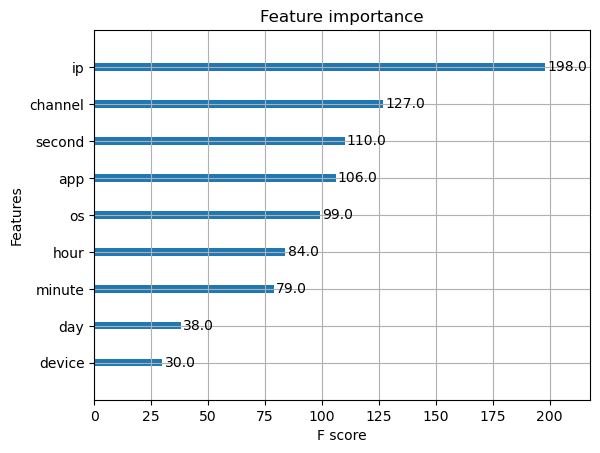

In [6]:
# Convert the training and validation datasets to DMatrix format (optimized for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

# Train the model with early stopping
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
model = xgb.train(params, dtrain, num_boost_round=100, evals=watchlist, early_stopping_rounds=10, verbose_eval=10)

# Display the best iteration
print(f"Best iteration: {model.best_iteration}")

# Plot feature importance to see the most significant features
plot_importance(model)
plt.show()

In [7]:
# Predict on the validation set
if hasattr(model, 'best_ntree_limit'):
    # Use best_ntree_limit if early stopping is applied
    y_pred = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
else:
    # Use all trees if early stopping is not applied
    y_pred = model.predict(dvalid)

# Save the trained model to a file
model.save_model('xgboost_model.json')

# Display the first few predictions
print(y_pred[:10])


[0.0009294  0.00022135 0.00039538 0.00081644 0.00084685 0.00091965
 0.00078884 0.00294066 0.00138429 0.00081078]
